In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop, adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# For adding new activation function
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow.python.client import device_lib
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sns.set(style='white', context='notebook', palette='deep')

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus() #To check if GPU is detected

['/job:localhost/replica:0/task:0/device:GPU:0']

Load Data

In [3]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
print(np.shape(train))
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


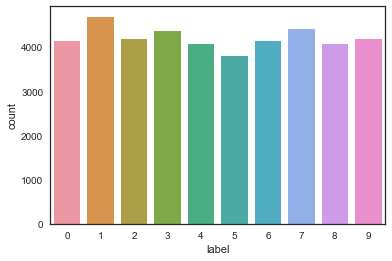

In [5]:
X_train = train.drop(labels = ["label"],axis = 1) #storing the training images
Y_train = train["label"]  #extracting training output labels

# free some space
del train 

g = sns.countplot(Y_train)

In [6]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [7]:
# Reshape image in 3 dimensions (height = 28, width = 28 , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
# Encode labels to one hot vectors
Y_train = to_categorical(Y_train, num_classes = 10)

In [9]:
# Set the random seed
random_seed = 2

# Split the train and the validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [10]:
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': swish})

In [11]:
# Set the CNN model 

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='swish'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "swish"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [12]:
# Define the optimizer
optimizer = adam(lr=0.001,  epsilon=1e-08, decay=0.0)
#optimizer=adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile the model
#model.compile(optimizer = optimizer , loss = "mean_squared_error", metrics=["accuracy"])
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [13]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
epochs = 30
batch_size = 86

In [15]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)
print(np.shape(X_train))

(37800, 28, 28, 1)


In [16]:
# Fit the model
#with tf.device('/cpu:0'):
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction]
                             )

Epoch 1/30
439/439 [==============================] - 126s 287ms/step - loss: 0.3997 - acc: 0.8707 - val_loss: 0.0667 - val_acc: 0.9783
Epoch 2/30
439/439 [==============================] - 67s 153ms/step - loss: 0.1237 - acc: 0.9620 - val_loss: 0.0564 - val_acc: 0.9829
Epoch 3/30
439/439 [==============================] - 67s 154ms/step - loss: 0.0959 - acc: 0.9712 - val_loss: 0.0396 - val_acc: 0.9879
Epoch 4/30
439/439 [==============================] - 70s 159ms/step - loss: 0.0849 - acc: 0.9750 - val_loss: 0.0433 - val_acc: 0.9871
Epoch 5/30
439/439 [==============================] - 67s 153ms/step - loss: 0.0711 - acc: 0.9787 - val_loss: 0.0227 - val_acc: 0.9921
Epoch 6/30
439/439 [==============================] - 61s 139ms/step - loss: 0.0620 - acc: 0.9814 - val_loss: 0.0315 - val_acc: 0.9910
Epoch 7/30
439/439 [==============================] - 64s 146ms/step - loss: 0.0603 - acc: 0.9807 - val_loss: 0.0313 - val_acc: 0.9910
Epoch 8/30
439/439 [==============================] - 

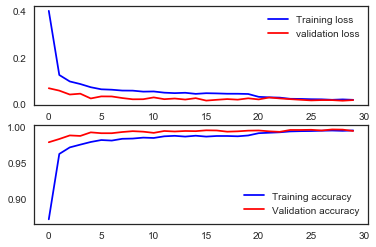

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

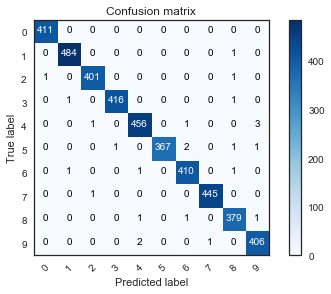

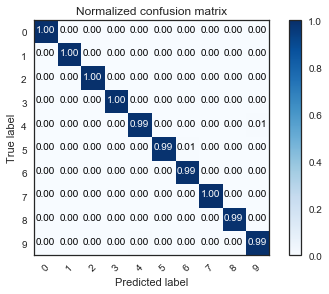

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_val,axis = 1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

class_names = range(10)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

total error: (25,)


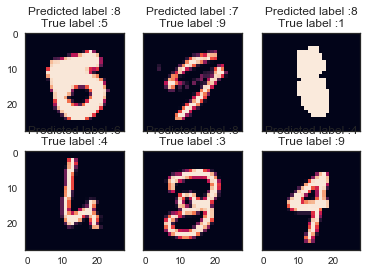

In [19]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred - y_true != 0)

Y_pred_classes_errors = y_pred[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

print('total error:',sorted_dela_errors.shape)

In [20]:
model.save('my_model.h5')

# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [21]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)